## Plot variant-effect prediction profile and observed SNV positions for windows with varying degrees of predicted constraint

In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

FILENAME_PREFIX = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/enhancer-characteristics-enrichment-subset' 

from numpy import linalg as LA
import pandas as pd 
import numpy as np 

import pysam 

import sys 
sys.path.append(f'{CONSTRAINT_TOOLS}/predict-constraint/germline-model')
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

from expected_observed_counts import compute_SNV_positions_frequencies
from read_model import read_model
from bases import BASES 

MCHALE_MODEL = read_model(f"{CONSTRAINT_TOOLS}/dist/model-germline-grch38-Nonly.kmerSize-3.trainSet-noncoding.json")

In [59]:
def compute_heat_map(window, embeddings): 
  chromosome = window['chromosome']
  start = int(window['start'])
  end = int(window['end'])

  with pysam.FastaFile(MCHALE_MODEL['genome']) as genome:
    # "fetch" API: https://pysam.readthedocs.io/en/latest/api.html?highlight=fasta#pysam.FastaFile
    # Note that fetch(region=region) does not work if the coordinates in "region" contains commas
    # Workaround is to parse "region" into "chromosome", "start", "end": 
    sequence = genome.fetch(chromosome, start, end)    
    sequence = sequence.upper()

  distances_for_all_sites = []
  sequence = sequence[:3] # TODO: remove 
  for site_index, REF in enumerate(sequence): 
    REF_index = BASES.index(REF)
    REF_embedding = embeddings[REF_index, site_index]
    distances_for_site = []
    for allele_index in range(len(BASES)): 
      embedding = embeddings[allele_index, site_index]
      delta = REF_embedding - embedding

      # section A.5.2 of https://www.biorxiv.org/content/10.1101/2023.01.11.523679v2
      # details metrics that could be used to quantify distance between embeddings: 
      #    (i) the L1 distance (Manhattan), 
      #    (ii) the L2 distance (Euclidean), 
      #    (iii) the cosine similarity 
      #    (iv) the dot-product (not normalized cosine similarity) 
      distance = LA.norm(delta, 2) 

      distances_for_site.append(distance)
    distances_for_all_sites.append(distances_for_site)
  distances_for_all_sites = np.array(distances_for_all_sites)
  heat_map = distances_for_all_sites.T 

  return heat_map # indexed as BASES X [site1, site2, ...]

def compute_heat_map_wrapper(window_index): 
  window = pd.read_pickle(f'{FILENAME_PREFIX}.{window_index}.pkl')  
  embeddings = np.load(f'{FILENAME_PREFIX}.{window_index}.npy')
  return compute_heat_map(window, embeddings)

compute_heat_map_wrapper(window_index=0)

array([[56.481552,  0.      , 54.38895 ],
       [ 0.      , 65.587105, 48.033203],
       [45.61755 , 41.731045,  0.      ],
       [49.853977, 49.757755, 47.099697]], dtype=float32)

In [14]:
from pack_unpack import pack

def get_snvs(window): 
  region = pack(window['chromosome'], window['start'], window['end'])
  
  with pysam.TabixFile(MCHALE_MODEL['mutations']) as mutations, pysam.FastaFile(MCHALE_MODEL['genome']) as genome:
    (
      SNV_positions_frequencies_CpG_positive, 
      SNV_positions_frequencies_CpG_negative
    ) = compute_SNV_positions_frequencies(mutations, genome, region, MCHALE_MODEL)
  return (
    SNV_positions_frequencies_CpG_positive, 
    SNV_positions_frequencies_CpG_negative,
  )

def get_snvs_wrapper(window_index): 
  window = pd.read_pickle(f'{FILENAME_PREFIX}.{window_index}.pkl')  
  return get_snvs(window)

get_snvs_wrapper(window_index=0)

(((100862181,
   100862182,
   100862354,
   100862355,
   100862392,
   100862393,
   100862592,
   100862593,
   100862690,
   100862691,
   100862703,
   100862711),
  (20, 25, 2, 4, 11, 1, 2, 16, 982, 2, 10, 13)),
 ((100862000,
   100862004,
   100862007,
   100862012,
   100862013,
   100862015,
   100862015,
   100862022,
   100862027,
   100862032,
   100862035,
   100862050,
   100862050,
   100862057,
   100862067,
   100862072,
   100862081,
   100862086,
   100862091,
   100862098,
   100862100,
   100862119,
   100862123,
   100862123,
   100862124,
   100862127,
   100862130,
   100862136,
   100862142,
   100862142,
   100862146,
   100862147,
   100862159,
   100862161,
   100862173,
   100862186,
   100862191,
   100862193,
   100862197,
   100862198,
   100862204,
   100862205,
   100862210,
   100862211,
   100862213,
   100862238,
   100862246,
   100862273,
   100862291,
   100862294,
   100862313,
   100862327,
   100862328,
   100862331,
   100862332,
   100862336

zscore quantile: 0.0 - 0.005


array([[56.481552,  0.      , 54.38895 ],
       [ 0.      , 65.587105, 48.033203],
       [45.61755 , 41.731045,  0.      ],
       [49.853977, 49.757755, 47.099697]], dtype=float32)

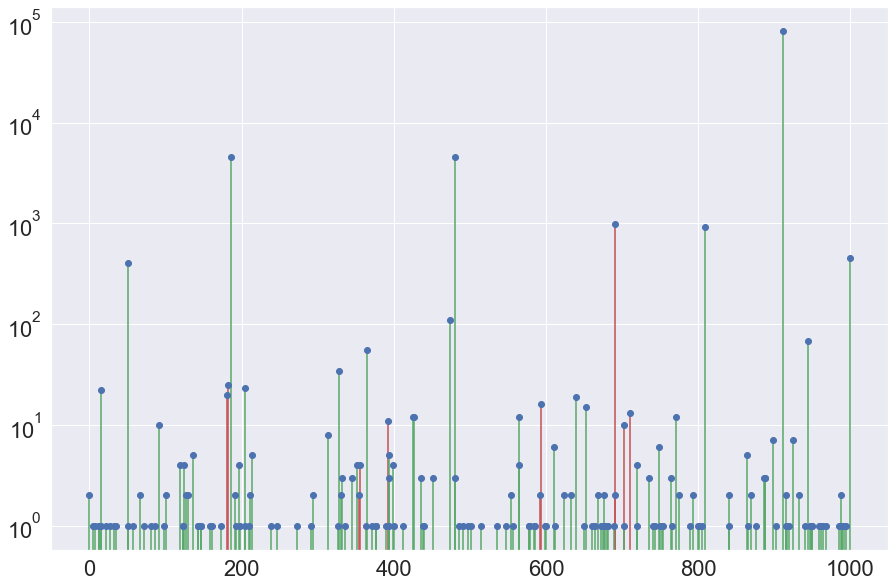

In [62]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set(font_scale=2)

plt.rcParams.update({
  'figure.figsize': (15, 10),
  # 'axes.facecolor': 'white'
})

def plot_stem(SNV_positions_frequencies, color, start): 
  x, y = SNV_positions_frequencies
  x = np.array(x)
  x -= start # TODO: check if this is off-by-one
  plt.stem(x, y, color)
  plt.yscale('log')

def plot_snvs_and_heat_map(window_index): 
  window = pd.read_pickle(f'{FILENAME_PREFIX}.{window_index}.pkl')  
  embeddings = np.load(f'{FILENAME_PREFIX}.{window_index}.npy')

  print(f"zscore quantile: {window['negative new chen zscore quantile']}") 
  start = int(window['start'])

  (
    SNV_positions_frequencies_CpG_positive, 
    SNV_positions_frequencies_CpG_negative,
  ) = get_snvs(window)
  plot_stem(SNV_positions_frequencies_CpG_positive, 'r', start)
  plot_stem(SNV_positions_frequencies_CpG_negative, 'g', start)
  
  heat_map = compute_heat_map(window, embeddings)
  return heat_map

  # plot variant-effect 4*L heat map
  #     c.f., experiments/germline-model/chen-et-al-2022/interplay-of-constraint-and-sequence-feature-composition.1.ipynb

plot_snvs_and_heat_map(window_index=0)

## [TODO] Hypothesis test
outlined in 2a: https://docs.google.com/presentation/d/1naB2zEBWXLoQOP9ioMDe77FlP8dhb63Eu8P_G6Jdpac/edit#slide=id.g22afc145c47_0_8

## [Other resources] Get attention maps
Here is an example on how to retrieve attention maps at a specific layer for a given head and how to plot them.

In [ ]:
print(outs["attention_map_layer_1_number_4"].shape)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns 

sns.set_theme(
    font_scale=2,
    rc={'figure.figsize': (16, 6)}
)

# plot attention maps
fig, axes = plt.subplots(nrows=1, ncols=2)

seq_length0, seq_length1 = int(sequences_lengths[0]), int(sequences_lengths[1])

# plot for first seq in the batch
im0 = axes[0].imshow(
    outs["attention_map_layer_1_number_4"][
        0, 1:(seq_length0 + 1), 1:(seq_length0 + 1)
    ]
)
divider0 = make_axes_locatable(axes[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
tokens0 = tokens_str[0][1 : (seq_length0 + 1)]
axes[0].set_xticks(list(range(seq_length0)))
axes[0].set_xticklabels(tokens0, rotation=45)
axes[0].set_yticks(list(range(seq_length0)))
axes[0].set_yticklabels(tokens0, rotation=45)
axes[0].grid(False)
fig.colorbar(im0, cax=cax0, orientation="vertical")

# plot for second seq in the batch
im1 = axes[1].imshow(
    outs["attention_map_layer_1_number_4"][
        1, 1:(seq_length1 + 1), 1:(seq_length1 + 1)
    ]
)
divider1 = make_axes_locatable(axes[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
tokens1 = tokens_str[1][1 : (seq_length1 + 1)]
axes[1].set_xticks(list(range(seq_length1)))
axes[1].set_xticklabels(tokens1, rotation=45)
axes[1].set_yticks(list(range(seq_length1)))
axes[1].set_yticklabels(tokens1, rotation=45)
axes[1].grid(False)
fig.colorbar(im1, cax=cax1, orientation="vertical")

fig.tight_layout()

## [Other resources] Get probabilities
Finally, let's look at the model probabilities over the vocabulary at each position. These can be used to compute reconstruction accuracies and perplexities.

In [ ]:
logits = outs["logits"]
probabilities = []

# get probabilities separately for each seq as they have different lengths
for seq_id in range(logits.shape[0]):

    logits_seq = logits[seq_id]
    seq_length = int(sequences_lengths[seq_id])
    logits_seq = logits_seq[1 : (seq_length + 1)]  # remove CLS token and pads
    probas = jax.nn.softmax(
        logits_seq, axis=-1
    )  # use softmax to transform logits into probabilities

    print(probas.shape)
    probabilities.append(probas)

Let's look in particular at a given sequence and position and show the top-k probabilities and corresponding tokens.

In [ ]:
sequence_id = 0
position_id = 1

probs = probabilities[sequence_id][position_id]
sorted_positions = jnp.argsort(-probs)
sorted_probs = probs[sorted_positions]

top_k = 5
for k in range(top_k):
    predicted_token = tokenizer.id_to_token(int(sorted_positions[k]))
    prob = sorted_probs[k]
    print(f"token: {predicted_token}, probability: {prob * 100:.2f}%")